In [38]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import argparse
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
def load_pep_and_codify(file, max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
        'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
    pep_codes=[]
    long_pep_counter = 0
    newLines = []
    for pep in lines:
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(current_pep)
            newLines.extend([pep])
        else:
            long_pep_counter += 1
    predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)
    return predict_data, long_pep_counter, newLines

In [3]:
file_path = 'compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/'
args = file_path + 'inputExample.txt'

print('Loading model...')
model_2_1D = keras.models.load_model(file_path + 'model_2_1D.h5')
print(model_2_1D.summary())

print('Loading input peptides')
predict_data, skipped, lines = load_pep_and_codify(args, 81)
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

print('Making predictions')
model_2_1D_pred = model_2_1D.predict(predict_data)
model_2_1D_pred = np.hstack((np.array(lines).reshape(len(lines), 1),model_2_1D_pred)).tolist()

Pred_output = []
for pred in model_2_1D_pred:
    if float(pred[1]) > 0.5:
        # pred.extend('0')
        Pred_output.append([pred[0], str(1-float(pred[1])), '0'])
    else:
        Pred_output.append([pred[0], str(1-float(pred[1])), '1'])
        # pred.extend('1')

outFile = '{0}_Predictions.txt'.format(args.split('.')[0])
print('Saving predictions to file {}'.format(outFile))
with open(outFile, 'w') as outf:
    outf.write('Peptide\tProb\tDetectability\n')
    outf.writelines('\t'.join(i) + '\n' for i in Pred_output)

Loading model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 50)            1150      
_________________________________________________________________
dropout_2 (Dropout)          (None, 81, 50)            0         
_________________________________________________________________

# original param

In [36]:
_, test_acc, test_loss = model_2_1D.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

67298/67298 [==============================] - 5s 74us/sample - loss: 2.6481 - acc: 0.2395 - binary_crossentropy: 2.6481
Test Loss: 2.6481499671936035
Test Accuracy: 0.2395019233226776


              precision    recall  f1-score   support

           0       0.22      0.20      0.21     33706
           1       0.26      0.28      0.27     33592

    accuracy                           0.24     67298
   macro avg       0.24      0.24      0.24     67298
weighted avg       0.24      0.24      0.24     67298

rf auc : 0.1697024360705187


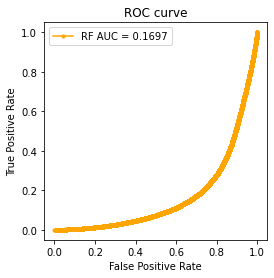

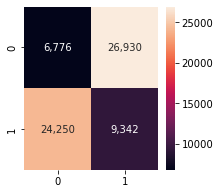

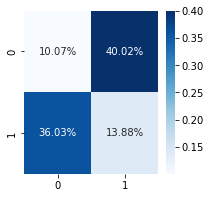

In [37]:
# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_2_1D.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model_2_1D.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_2_1D
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

# New Train

In [41]:
model = tf.keras.Sequential([
    # vacabulary size 23 (22 AminoAcid + zero padding)
    # embedding vector size 50
    # input length (including padding) 30 ( 81 to 30)
    tf.keras.layers.Embedding(23, 50, input_length=30),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, strides=1),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 50)            1150      
_________________________________________________________________
dropout_10 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 30, 128)           19328     
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 29, 64)            16448     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)               

# 1. Make Data X_train, y_train, X_test, y_test

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = 'compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/'

In [43]:
# make DeepMSpeptide format
df_peptide_train = pd.read_csv('data/df_detect_peptide_train.csv')
df_peptide_test = pd.read_csv('data/df_detect_peptide_test.csv')

inp = open(file_path+'detect_peptide_train.txt', 'w')
inp_y = open(file_path+'detect_peptide_train_y.txt', 'w')
for x, y in df_peptide_train[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

inp = open(file_path+'detect_peptide_test.txt', 'w')
inp_y = open(file_path+'detect_peptide_test_y.txt', 'w')
for x, y in df_peptide_test[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

args = file_path + 'detect_peptide_train.txt'
print('Loading input peptides')
X_train, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_train_y.txt')
y_train = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'detect_peptide_test.txt'
print('Loading input peptides')
X_test, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_test_y.txt')
y_test = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

Loading input peptides
Succesfully loaded 269190 peptides and skipped 0
Loading input peptides
Succesfully loaded 67298 peptides and skipped 0
(215352, 30) (53838, 30) (67298, 30) (215352,) (53838,) (67298,)


# 2. train

In [4]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [44]:
history = model.fit(X_train, y_train, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val, y_val))

Train on 215352 samples, validate on 53838 samples
Epoch 1/200
215352/215352 [==============================] - 23s 105us/sample - loss: 0.6304 - acc: 0.7076 - val_loss: 0.6146 - val_acc: 0.7588
Epoch 2/200
215352/215352 [==============================] - 22s 102us/sample - loss: 0.6106 - acc: 0.7686 - val_loss: 0.6126 - val_acc: 0.7688
Epoch 3/200
215352/215352 [==============================] - 22s 101us/sample - loss: 0.6088 - acc: 0.7737 - val_loss: 0.6107 - val_acc: 0.7736
Epoch 4/200
215352/215352 [==============================] - 22s 100us/sample - loss: 0.6073 - acc: 0.7781 - val_loss: 0.6100 - val_acc: 0.7685
Epoch 5/200
215352/215352 [==============================] - 22s 101us/sample - loss: 0.6066 - acc: 0.7806 - val_loss: 0.6092 - val_acc: 0.7795
Epoch 6/200
215352/215352 [==============================] - 22s 101us/sample - loss: 0.6061 - acc: 0.7812 - val_loss: 0.6089 - val_acc: 0.7813
Epoch 7/200
215352/215352 [==============================] - 22s 100us/sample - loss:

215352/215352 [==============================] - 22s 100us/sample - loss: 0.5904 - acc: 0.8104 - val_loss: 0.5956 - val_acc: 0.7969
Epoch 58/200
215352/215352 [==============================] - 22s 101us/sample - loss: 0.5903 - acc: 0.8102 - val_loss: 0.5958 - val_acc: 0.7943
Epoch 59/200
215352/215352 [==============================] - 22s 102us/sample - loss: 0.5900 - acc: 0.8112 - val_loss: 0.5952 - val_acc: 0.7999
Epoch 60/200
215352/215352 [==============================] - 22s 101us/sample - loss: 0.5900 - acc: 0.8109 - val_loss: 0.5954 - val_acc: 0.7970
Epoch 61/200
215352/215352 [==============================] - 22s 101us/sample - loss: 0.5896 - acc: 0.8120 - val_loss: 0.5953 - val_acc: 0.8006
Epoch 62/200
215352/215352 [==============================] - 22s 101us/sample - loss: 0.5895 - acc: 0.8119 - val_loss: 0.5952 - val_acc: 0.7975
Epoch 63/200
215352/215352 [==============================] - 22s 101us/sample - loss: 0.5894 - acc: 0.8116 - val_loss: 0.5949 - val_acc: 0.799

215352/215352 [==============================] - 22s 102us/sample - loss: 0.5841 - acc: 0.8223 - val_loss: 0.5929 - val_acc: 0.8097
Epoch 114/200
215352/215352 [==============================] - 22s 102us/sample - loss: 0.5840 - acc: 0.8231 - val_loss: 0.5929 - val_acc: 0.8099
Epoch 115/200
215352/215352 [==============================] - 22s 102us/sample - loss: 0.5840 - acc: 0.8227 - val_loss: 0.5930 - val_acc: 0.7996
Epoch 116/200
215352/215352 [==============================] - 22s 102us/sample - loss: 0.5837 - acc: 0.8236 - val_loss: 0.5925 - val_acc: 0.8099
Epoch 117/200
215352/215352 [==============================] - 22s 102us/sample - loss: 0.5837 - acc: 0.8234 - val_loss: 0.5926 - val_acc: 0.8076
Epoch 118/200
215352/215352 [==============================] - 22s 102us/sample - loss: 0.5838 - acc: 0.8236 - val_loss: 0.5927 - val_acc: 0.8075
Epoch 119/200
215352/215352 [==============================] - 22s 103us/sample - loss: 0.5836 - acc: 0.8241 - val_loss: 0.5927 - val_acc:

215352/215352 [==============================] - 22s 102us/sample - loss: 0.5812 - acc: 0.8291 - val_loss: 0.5919 - val_acc: 0.8066
Epoch 170/200
215352/215352 [==============================] - 22s 101us/sample - loss: 0.5812 - acc: 0.8288 - val_loss: 0.5920 - val_acc: 0.8109
Epoch 171/200
215352/215352 [==============================] - 22s 102us/sample - loss: 0.5812 - acc: 0.8285 - val_loss: 0.5920 - val_acc: 0.8061
Epoch 172/200
215352/215352 [==============================] - 22s 101us/sample - loss: 0.5811 - acc: 0.8288 - val_loss: 0.5915 - val_acc: 0.8075
Epoch 173/200
215352/215352 [==============================] - 22s 101us/sample - loss: 0.5811 - acc: 0.8293 - val_loss: 0.5921 - val_acc: 0.8061
Epoch 174/200
215352/215352 [==============================] - 22s 101us/sample - loss: 0.5810 - acc: 0.8297 - val_loss: 0.5917 - val_acc: 0.8055
Epoch 175/200
215352/215352 [==============================] - 22s 102us/sample - loss: 0.5810 - acc: 0.8292 - val_loss: 0.5917 - val_acc:

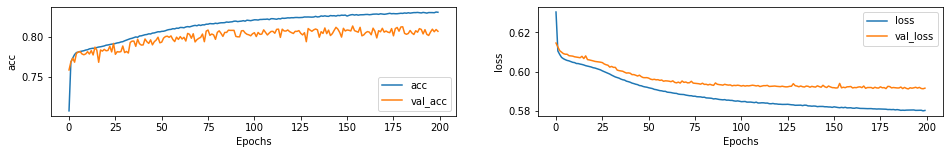

In [45]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'acc')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# 3. test

In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [46]:
print('Making predictions')
model_pred = model.predict(X_test)
model_pred = np.hstack((np.array(lines).reshape(len(lines), 1),model_pred)).tolist()

Pred_output = []
for pred in model_pred:
    if float(pred[1]) > 0.5:
        Pred_output.append([pred[0], str(1-float(pred[1])), '0'])
    else:
        Pred_output.append([pred[0], str(1-float(pred[1])), '1'])

outFile = '{0}_Predictions.txt'.format(args.split('.')[0])
print('Saving predictions to file {}'.format(outFile))
with open(outFile, 'w') as outf:
    outf.write('Peptide\tProb\tDetectability\n')
    outf.writelines('\t'.join(i) + '\n' for i in Pred_output)

Making predictions
Saving predictions to file compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/detect_peptide_test_Predictions.txt


In [47]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

67298/67298 [==============================] - 4s 61us/sample - loss: 0.5902 - acc: 0.8091
Test Loss: 0.5901626553318363
Test Accuracy: 0.8090581893920898


              precision    recall  f1-score   support

           0       0.77      0.88      0.82     33706
           1       0.86      0.74      0.79     33592

    accuracy                           0.81     67298
   macro avg       0.81      0.81      0.81     67298
weighted avg       0.81      0.81      0.81     67298

rf auc : 0.8719300384125104


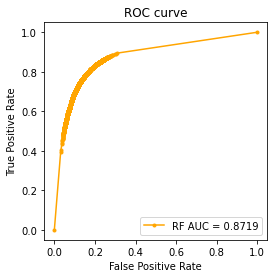

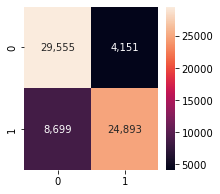

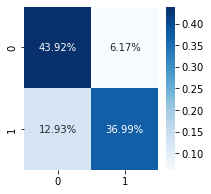

In [48]:
# prediction
y_pred = [1 if i>=0.5 else 0 for i in model.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

# max_length 81

In [50]:
args = file_path + 'detect_peptide_train.txt'
print('Loading input peptides')
X_train, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'detect_peptide_train_y.txt')
y_train = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'detect_peptide_test.txt'
print('Loading input peptides')
X_test, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'detect_peptide_test_y.txt')
y_test = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

Loading input peptides
Succesfully loaded 269190 peptides and skipped 0
Loading input peptides
Succesfully loaded 67298 peptides and skipped 0
(215352, 81) (53838, 81) (67298, 81) (215352,) (53838,) (67298,)


In [53]:
model81 = tf.keras.Sequential([
    tf.keras.layers.Embedding(23, 50, input_length=81),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, strides=1),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model81.summary()
model81.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 81, 50)            1150      
_________________________________________________________________
dropout_16 (Dropout)         (None, 81, 50)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 81, 128)           19328     
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 80, 64)            16448     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)               

In [54]:
history = model81.fit(X_train, y_train, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val, y_val))

Train on 215352 samples, validate on 53838 samples
Epoch 1/200
215352/215352 [==============================] - 26s 120us/sample - loss: 0.6281 - acc: 0.7144 - val_loss: 0.6143 - val_acc: 0.7554
Epoch 2/200
215352/215352 [==============================] - 25s 116us/sample - loss: 0.6100 - acc: 0.7715 - val_loss: 0.6117 - val_acc: 0.7690
Epoch 3/200
215352/215352 [==============================] - 25s 117us/sample - loss: 0.6089 - acc: 0.7759 - val_loss: 0.6106 - val_acc: 0.7737
Epoch 4/200
215352/215352 [==============================] - 25s 117us/sample - loss: 0.6081 - acc: 0.7787 - val_loss: 0.6103 - val_acc: 0.7733
Epoch 5/200
215352/215352 [==============================] - 25s 117us/sample - loss: 0.6075 - acc: 0.7805 - val_loss: 0.6103 - val_acc: 0.7711
Epoch 6/200
215352/215352 [==============================] - 25s 117us/sample - loss: 0.6071 - acc: 0.7810 - val_loss: 0.6094 - val_acc: 0.7808
Epoch 7/200
215352/215352 [==============================] - 25s 117us/sample - loss:

215352/215352 [==============================] - 25s 117us/sample - loss: 0.5935 - acc: 0.8053 - val_loss: 0.5997 - val_acc: 0.7896
Epoch 58/200
215352/215352 [==============================] - 25s 116us/sample - loss: 0.5930 - acc: 0.8067 - val_loss: 0.5999 - val_acc: 0.7959
Epoch 59/200
215352/215352 [==============================] - 25s 117us/sample - loss: 0.5930 - acc: 0.8067 - val_loss: 0.5995 - val_acc: 0.7979
Epoch 60/200
215352/215352 [==============================] - 25s 117us/sample - loss: 0.5925 - acc: 0.8069 - val_loss: 0.5993 - val_acc: 0.7947
Epoch 61/200
215352/215352 [==============================] - 25s 117us/sample - loss: 0.5925 - acc: 0.8074 - val_loss: 0.5990 - val_acc: 0.7928
Epoch 62/200
215352/215352 [==============================] - 25s 117us/sample - loss: 0.5922 - acc: 0.8072 - val_loss: 0.5992 - val_acc: 0.7897
Epoch 63/200
215352/215352 [==============================] - 25s 117us/sample - loss: 0.5918 - acc: 0.8086 - val_loss: 0.5988 - val_acc: 0.791

215352/215352 [==============================] - 32s 150us/sample - loss: 0.5856 - acc: 0.8213 - val_loss: 0.5978 - val_acc: 0.7945
Epoch 114/200
215352/215352 [==============================] - 32s 150us/sample - loss: 0.5856 - acc: 0.8209 - val_loss: 0.5980 - val_acc: 0.7987
Epoch 115/200
215352/215352 [==============================] - 33s 151us/sample - loss: 0.5854 - acc: 0.8215 - val_loss: 0.5982 - val_acc: 0.8000
Epoch 116/200
215352/215352 [==============================] - 33s 153us/sample - loss: 0.5854 - acc: 0.8213 - val_loss: 0.5989 - val_acc: 0.8016
Epoch 117/200
215352/215352 [==============================] - 33s 151us/sample - loss: 0.5851 - acc: 0.8220 - val_loss: 0.5983 - val_acc: 0.8012
Epoch 118/200
215352/215352 [==============================] - 32s 150us/sample - loss: 0.5852 - acc: 0.8218 - val_loss: 0.5985 - val_acc: 0.8007
Epoch 119/200
215352/215352 [==============================] - 32s 149us/sample - loss: 0.5853 - acc: 0.8214 - val_loss: 0.5978 - val_acc:

215352/215352 [==============================] - 33s 152us/sample - loss: 0.5831 - acc: 0.8260 - val_loss: 0.5984 - val_acc: 0.7945
Epoch 170/200
215352/215352 [==============================] - 32s 149us/sample - loss: 0.5829 - acc: 0.8265 - val_loss: 0.5986 - val_acc: 0.7957
Epoch 171/200
215352/215352 [==============================] - 32s 150us/sample - loss: 0.5828 - acc: 0.8272 - val_loss: 0.5989 - val_acc: 0.7964
Epoch 172/200
215352/215352 [==============================] - 32s 149us/sample - loss: 0.5828 - acc: 0.8264 - val_loss: 0.5983 - val_acc: 0.7970
Epoch 173/200
215352/215352 [==============================] - 32s 150us/sample - loss: 0.5828 - acc: 0.8268 - val_loss: 0.5984 - val_acc: 0.7909
Epoch 174/200
215352/215352 [==============================] - 32s 149us/sample - loss: 0.5827 - acc: 0.8271 - val_loss: 0.5987 - val_acc: 0.7971
Epoch 175/200
215352/215352 [==============================] - 32s 150us/sample - loss: 0.5826 - acc: 0.8274 - val_loss: 0.5987 - val_acc:

67298/67298 [==============================] - 4s 66us/sample - loss: 0.5980 - acc: 0.8034
Test Loss: 0.5979600409249246
Test Accuracy: 0.8034265637397766
              precision    recall  f1-score   support

           0       0.79      0.83      0.81     33706
           1       0.82      0.78      0.80     33592

    accuracy                           0.80     67298
   macro avg       0.80      0.80      0.80     67298
weighted avg       0.80      0.80      0.80     67298

rf auc : 0.8447956466848292


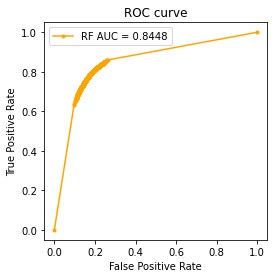

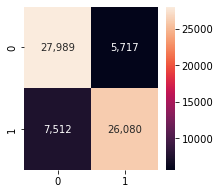

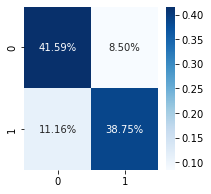

In [55]:
test_loss, test_acc = model81.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model81.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model81.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model81
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()